### Conv neural network w/ pytorch

In [1]:
# https://pythonprogramming.net/introduction-deep-learning-neural-network-pytorch/
import os
import cv2
import numpy as np
# notebook for lab instead of tqdm which is more for terminal apps; still having issues though
# https://pypi.org/project/tqdm/#ipython-jupyter-integration
# https://tqdm.github.io/docs/notebook/
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
REBUILD_DATA = False  # set to True for 1st run

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    training_data = []
    # use as counter while appending data, use to check for balance
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        # iterate over directories, which were given in full by the LABELS dictionary
        for label in self.LABELS:
            print(label)
            # get the file by iterating though all the files in that label's directory (listdir lists all files)
            # tqdm shows progress bar
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)  # get full path for the file
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # grayscale to make simpler for neural net
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    # np.eye creates identity matrix, taking the ith row of the matrix is like one hot encoding
                    self.training_data.append([np.array(img), np.eye(len(LABELS))[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                
                # if images have issues
                except Exception as e:
                    pass
                    # print(str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

### Visualise training data

24946
[array([[51, 49, 49, ...,  6,  6,  7],
       [72, 72, 65, ...,  6,  6,  7],
       [59, 72, 80, ...,  7,  7,  8],
       ...,
       [14, 24, 23, ..., 44, 37, 39],
       [80, 26, 38, ..., 38, 35, 38],
       [99, 73, 27, ...,  4,  3, 38]], dtype=uint8)
 array([1., 0.])]
[array([[ 35,  47,  85, ..., 105, 105,  97],
       [ 59,  59,  79, ...,   9,  20, 100],
       [151, 151, 152, ...,  62,  15,  82],
       ...,
       [ 92,  85,  61, ..., 115, 116, 114],
       [ 94,  59, 108, ..., 115, 111, 108],
       [ 65,  93, 107, ..., 107, 110, 108]], dtype=uint8)
 array([0., 1.])]


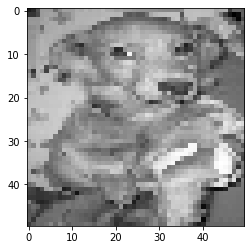

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)

# training_data[i] is the ith row of a feature and a one-hot encoded label
# training_data[i][0] is the feature; [i][1] is the label
print(len(training_data))
print(training_data[0])
print(training_data[1])

import matplotlib.pyplot as plt

plt.imshow(training_data[1][0], cmap="gray")
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()  # just run the init of parent class (nn.Module) https://realpython.com/python-super/
        # these are 2d layers but pytorch can take any dimensions
        self.conv1 = nn.Conv2d(1, 32, 5)  # input is 1 image, 32 output channels 5 is the kernel size
        self.conv2 = nn.Conv2d(32, 64, 5)  # based on 1st layer, then we decide output gets 64 channels
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        
        # old version of pytorch didn't have flatten function
        self.fc1 = nn.Linear(self._to_linear, 512)  # need to get the right size for input
        self.fc2 = nn.Linear(512, 2)  # 2 classes of cats and dogs
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # shape of pooling is 2x2
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        # print(x[0].shape) # returns torch.Size([128, 2, 2])
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]  # set the input if not already done 
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # x is a batch of x's,  
    
net = Net()

In [5]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0  # scaling the imagery since pixel values between 0 and 255
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(val_size)

2494


### Train test split

In [6]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


### Train

In [8]:
BATCH_SIZE = 100  # if getting memory error, this is easiest to change
EPOCHS = 1

# tqdm is progress bar
for epoch in tqdm(range(EPOCHS)):
    # split data starting from 0 to len(), in steps of BATCH_SIZE
    for i in tqdm(range(0, len(train_X), BATCH_SIZE), leave=False):
        # print(i, i + BATCH_SIZE)
        batch_X = train_X[i: i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i: i + BATCH_SIZE]
        
        net.zero_grad()  # zero gradients
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)


tensor(0.2147, grad_fn=<MseLossBackward>)


### Test function

In [10]:
def test(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct / total, 3))
    
test(net)


Accuracy: 0.599
